In [1]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import sys, os

from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd

import exp_parameters

%matplotlib notebook

In [2]:
# power law fit: n(T) = n0*(T/Ts-1))^(-gamma)
def power_law(x,a,b,c):
    return a*(x/b-1)**(-c)

### Parameters

In [8]:
# Functions for experimental parameters

# Implementation notes: DH
# Calculates the enthalpy of vaporization [J/mol] of water for a given temperature T [K].
    
def enthalpy_vap(T, algorithm=1):
    
# enthalpy of vap of water in J/mol: DH

# temperature of triple point for water in K
    Tt = 273.16;
    
# critical temperature of the gas-liquid critical point for water in K
    Tc = 647.126;

# reduced temperature w.r.t. the critical temperature
    X = (Tc - T)/(Tc - Tt)

    if (algorithm == 1):
# ALGORITHM 1 -- taken from Somayujulu, Int. J. Thermophysics 9, 567 (1988)
        DH = 1000*(44.457979*X**(3.0/8.0) + 14.635863*X**(1.0 + 3.0/8.0) - 27.945633*X**(2.0 + 3.0/8.0) + 13.985176*X**(3.0 + 3.0/8.0))                                             
    elif (algorithm == 2): 
# ALGORITHM 2 -- taken from Murphy & Koop, Quarterly Journal of the Royal Meteorological Society 131, 1539 (2005)
        DH = 56579.0 - 42.212*T + np.exp(0.1149*(281.6 - T))
    elif (algorithm == 3): 
# ALGORITHM 3 -- polynomial (T^5) fit to TIP4P/2005 simulation
        DH = 1000*(-187.44 + 4.70*T - 0.034769*T**2 + 0.00012385*T**3 - 2.1674E-7*T**4 + 1.4959e-10*T**5)
    elif (algorithm == 4): 
# ALGORITHM 4 -- polynomial (T^5) fit to TIP4P/2005 simulation scaled by 0.9701 to fit experiment at r.t.
        DH = 0.9701*1000*(-187.44 + 4.70*T - 0.034769*T**2 + 0.00012385*T**3 - 2.1674e-7*T**4 + 1.4959e-10*T**5)

    return(DH)

#############################################################
# Implementation notes: Cp
# Calculates the specific heat capacity [J/mol/K] of water for a given temperature T [K].

def heat_capacity(T, algorithm=1):
	
# heat capacity of water in J/mol/K: Cp

    if (algorithm == 1): 
    # ALGORITHM 1 -- taken from Angell, JPC 86, 998 (1982)
        Cp = 75.379992 + 80.5428*np.exp(0.110358*(226 - T))
    elif (algorithm == 2):
    # ALGORITHM 2 -- taken from Huang & Bartell, JPC 99, 3924 (1995)
        Cp = 72.92 + 0.01896 * (T - 226.0) + 41.7 / (1.0 + 0.0072 * (T - 226.0) * (T - 226.0))
    elif (algorithm == 3):
    # ALGORITHM 3 -- taken from Oguni, JCP 73, 1948 (1980)
        Cp = 67.85 + 2.309*(T/226.4 - 1.0)**(-0.933)
    elif (algorithm == 4):
    # ALGORITHM 4 -- constant (75.5 J/mol/K)
        Cp = 75.5
    elif (algorithm == 5):
    # ALGORITHM 5 -- polynomial (T^6) fit to experiment taken from Angell, JPC 86, 998 (1982)
        Cp = 0.5*(-4.918446910069158e-7*T**5 + 6.629043740464008e-004*T**4 - 0.357231756477509*T**3 + 96.219313730883627*T**2 - 1.295443543210677e+004*T + 6.975758920548891e+005 
                  + 1.796958801996025e-008*T**6 - 2.880415435149749e-005*T**5 + 0.019229566288177*T**4 - 6.843917968834040*T**3 + 1.369622281156036e+003*T**2 - 1.461343975335083e+005*T + 6.494963597586376e+006)
    elif (algorithm == 6):
    # ALGORITHM 6 -- power law fit (Ts = 226 K) to experiment taken from Angell, JPC 86, 998 (1982)
        Cp = 72.15583622 + 0.4398394*(T/226.0 - 1.0)**(-1.36432632)
    elif (algorithm == 7):
    # ALGORITHM 7 -- polynomial (T^8) fit to TIP4P/2005 simulation
        Cp = -0.2928*((T - 285.0)/53.3854)**8.0 + 1.7135*((T - 285.0)/53.3854)**7.0 - 2.4772*((T - 285.0)/53.3854)**6.0 - 1.2963*((T - 285.0)/53.3854)**5.0
        + 6.2057*((T - 285.0)/53.3854)**4.0 - 5.8421*((T - 285.0)/53.3854)**3.0 + 3.7122*((T - 285.0)/53.3854)**2.0 - 7.3977*(T - 285.0)/53.3854 + 91.0656
    elif (algorithm == 8):
    # ALGORITHM 8 -- polynomial (T^8) fit to TIP4P/2005 simulation scaled by 0.8258 to fit experiment at r.t.
        Cp = 0.8258*(-0.2928*((T - 285.0)/53.3854)**8.0 + 1.7135*((T - 285.0)/53.3854)**7.0 - 2.4772*((T - 285.0)/53.3854)**6.0 - 1.2963*((T - 285.0)/53.3854)**5.0
                     + 6.2057*((T - 285.0)/53.3854)**4.0 - 5.8421*((T - 285.0)/53.3854)**3.0 + 3.7122*((T - 285.0)/53.3854)**2.0 - 7.3977*(T - 285.0)/53.3854 + 91.0656)                                   

    return(Cp)


################################################

# Implementation notes: rho
# Calculates the density [kg/m^3] of water for a given temperature T [K].

def density(T, algorithm=1):

# density of water in kg/m^3: rho

    if (algorithm == 1):
    # ALGORITHM 1 -- interpolation of experimental density data of ice (Ih = 0.934 g/cm^3) and water taken from Kell, Journal of Chemical Engineering Data 20, 97 (1975)
        rho = 933.942 + 66.7829 / (1.0 + np.exp( - 0.10662 * (T - 233.0573)))
    elif (algorithm == 2):
    # ALGORITHM 2 -- taken from Hare & Sorensen, JCP 87, 4840 (1987)
        rho = 1000*(0.99986 + 6.69e-5*(T - 273.15) - 8.486e-6*(T - 273.15)*(T - 273.15) + 1.518e-7*(T - 273.15)*(T - 273.15)*(T - 273.15) - 6.9484e-9*(T - 273.15)*(T - 273.15)*(T - 273.15)*(T - 273.15) 
                - 3.6449e-10*(T - 273.15)*(T - 273.15)*(T - 273.15)*(T - 273.15)*(T - 273.15) - 7.497e-12*(T - 273.15)*(T - 273.15)*(T - 273.15)*(T - 273.15)*(T - 273.15)*(T - 273.15))
    elif (algorithm == 3):
    # ALGORITHM 3 -- polynomial (T^6) fit to TIP4P/2005 simulation
        rho = 199154.0 - 4798.08*T + 49.2902*T**2 - 0.278943*T**3 + 0.000940308*T**4 - 1.88965e-6*T**5 + 2.09734e-9*T**6 - 9.92214E-13*T**7
    elif (algorithm == 4):
    # ALGORITHM 4 -- polynomial (T^6) fit to TIP4P/2005 simulation scaled by 1.002 to reproduce experimental density maximum
        rho = 1.002*(199154.0 - 4798.08*T + 49.2902*T**2 - 0.278943*T**3 + 0.000940308*T**4 - 1.88965e-6*T**5 + 2.09734e-9*T**6 - 9.92214e-13*T**7)

    return(rho)


###################################################


# Implementation notes: Pvap
# Calculates the effective vapor pressure [Pa] of water from the droplet for a given temperature T [K] and backpressure in the chamber P0.

def Pvap(T, P0, algorithm=1):
    
# effective vapor pressure in Pa for supercooled water from the droplet: Pvap

# saturation (i.e. equilibrium) vapor pressure in Pa for supercooled water: Psat

# backpressure in the vacuum chamber: P0

# temperature of triple point for water in K
    Tt = 273.16;

# see http://cires.colorado.edu/~voemel/vp.html for summary of empirical expressions
    if (algorithm == 1):
    # ALGORITHM 1 -- taken from from Murphy & Koop, Quarterly Journal of the Royal Meteorological Society 131, 1539 (2005)
        Psat = np.exp(54.842763 - 6763.22/T - 4.210*np.log(T) + 0.000367*T + np.tanh(0.0415*(T - 218.8))*(53.878 - 1331.22/T - 9.44523*np.log(T) + 0.014025*T))
    elif (algorithm == 2):
    #ALGORITHM 2 -- taken from Hyland & Wexler, Special publication of the American Society of Heating, Project 216 (1982)
        Psat = np.exp(-0.58002206e4/T + 1.3914993 - 0.48640239e-1*T + 0.41764768e-4*T**2 - 0.14452093e-7*T**3 + 6.5459673*np.log(T))
    elif (algorithm == 3):
    # ALGORITHM 3 -- taken from Buck, Buck Research CR-1A User's Manual, Appendix 1 (1996)
        Psat = 611.21 * np.exp((18.678 - (T - 273.15)/234.5)*(T - 273.15)/(T - 16.01))
    elif (algorithm == 4):
    # ALGORITHM 4 -- recommended by WMO (2000), originally published by Goff, Transactions of the American Society of Heating and Ventilating Engineers, pp. 347 (1957)
        Psat = 100*10**((10.79574*(1 - Tt/T) - 5.02800*np.log10(T/Tt)+ 1.50475e-4*(1 - 10**(-8.2969*(T/Tt - 1))) 
                        + 0.42873e-3*(10**(4.76955*(1 - Tt/T)) - 1) + 0.78614))

# calculate the effective vapor pressure by subtracting the backpressure in the vacuum chamber (assumes it is all H2O)
    Pvap = Psat - P0

    return(Pvap)


##########################################################

# Implementation notes: kappa
# Calculates the thermal conductivity [W/m/K] of water for a given temperature T [K].

def thermal_cond(T, algorithm=1):

# thermal conductivity of water in W/m/K

    if (algorithm == 1):
    # ALGORITHM 1 -- polynomial (T^4) fit to experiment taken from CRC Handbook of Chemistry and Physics, 2nd ed., E-10
    # experimental data in the temperature range 250 K ≤ T ≤ 640 K)
        kappa = 0.1*((8.311169571874185e-12)*T**4 + (2.795759096697513e-8)*T**3 - (1.052493788349872e-4)*T**2 + 0.069481082649479*T - 6.093514692522149)
    elif (algorithm == 2):
    # ALGORITHM 2 -- taken from Ramires, NIST (1994)
    # expression recommended for 274 K ≤ T ≤ 370 K
    # thermal conductivity of water at r.t. 0.6065 +/- 0.0036 W/m/K
        kappa = 0.6065*(-1.48445 + 4.12292*T/298.15 - 1.63866*(T/298.15)*(T/298.15))

    return(kappa)
    
    
############################################################
    
# Implementation notes: tau
# Calculates the surface tension [N/m] of water for a given temperature T [K]: tau

def surf_tension(T, algorithm=1):

    # surface tension in N/m: tau

    if (algorithm == 1):
    # ALGORITHM 1 -- taken from Floriano & Angell, JCP 94, 10 (1990)
    # linear fit to data
        tau = (75.643 - 0.15186*(T - 273.15))*0.001

    return(tau)

In [9]:
temp = np.linspace(200,300)

<IPython.core.display.Javascript object>


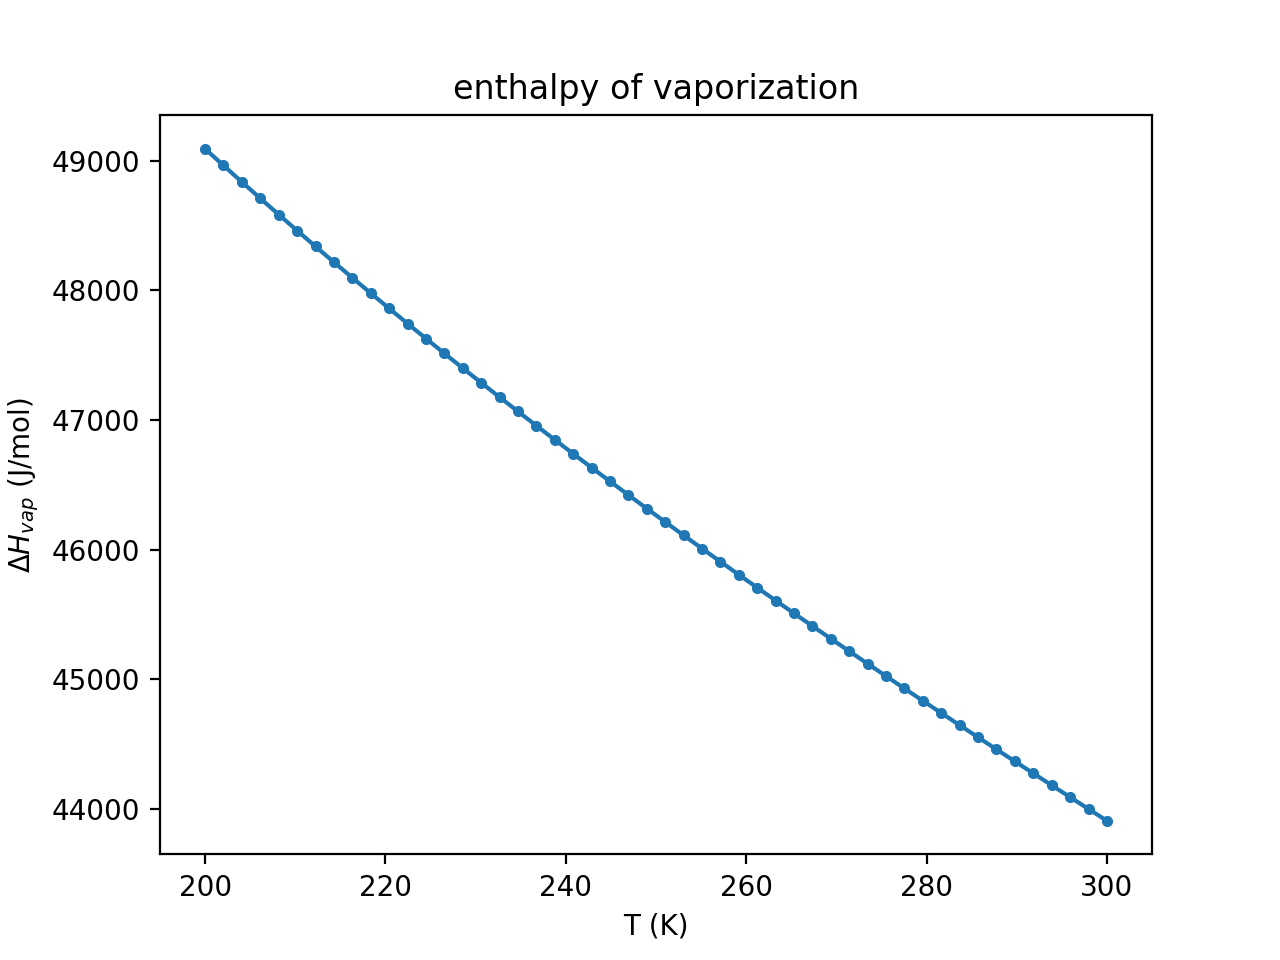

Text(0.5, 1.0, 'enthalpy of vaporization')

In [10]:
Hvap = enthalpy_vap(temp,algorithm=1)

plt.figure()
plt.plot(temp,Hvap,'.-')
plt.xlabel(r'T (K)')
plt.ylabel(r'$\Delta H_{vap}$ (J/mol)')
plt.title('enthalpy of vaporization')

<IPython.core.display.Javascript object>


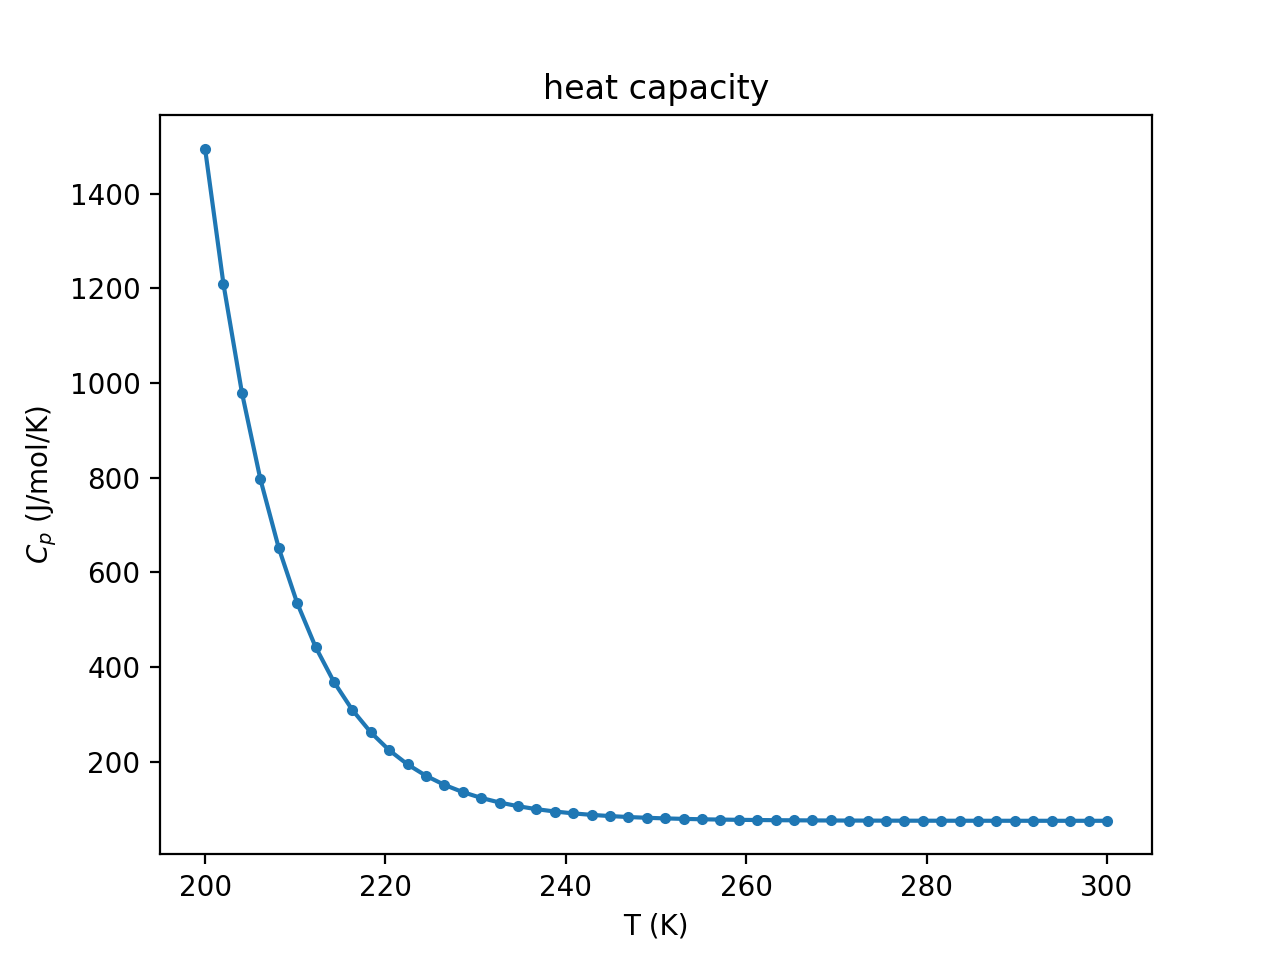

Text(0.5, 1.0, 'heat capacity')

In [11]:
Cp_vals = heat_capacity(temp,algorithm=1)

plt.figure()
plt.plot(temp,Cp_vals,'.-')
plt.xlabel(r'T (K)')
plt.ylabel(r'$C_{p}$ (J/mol/K)')
plt.title('heat capacity')

<IPython.core.display.Javascript object>


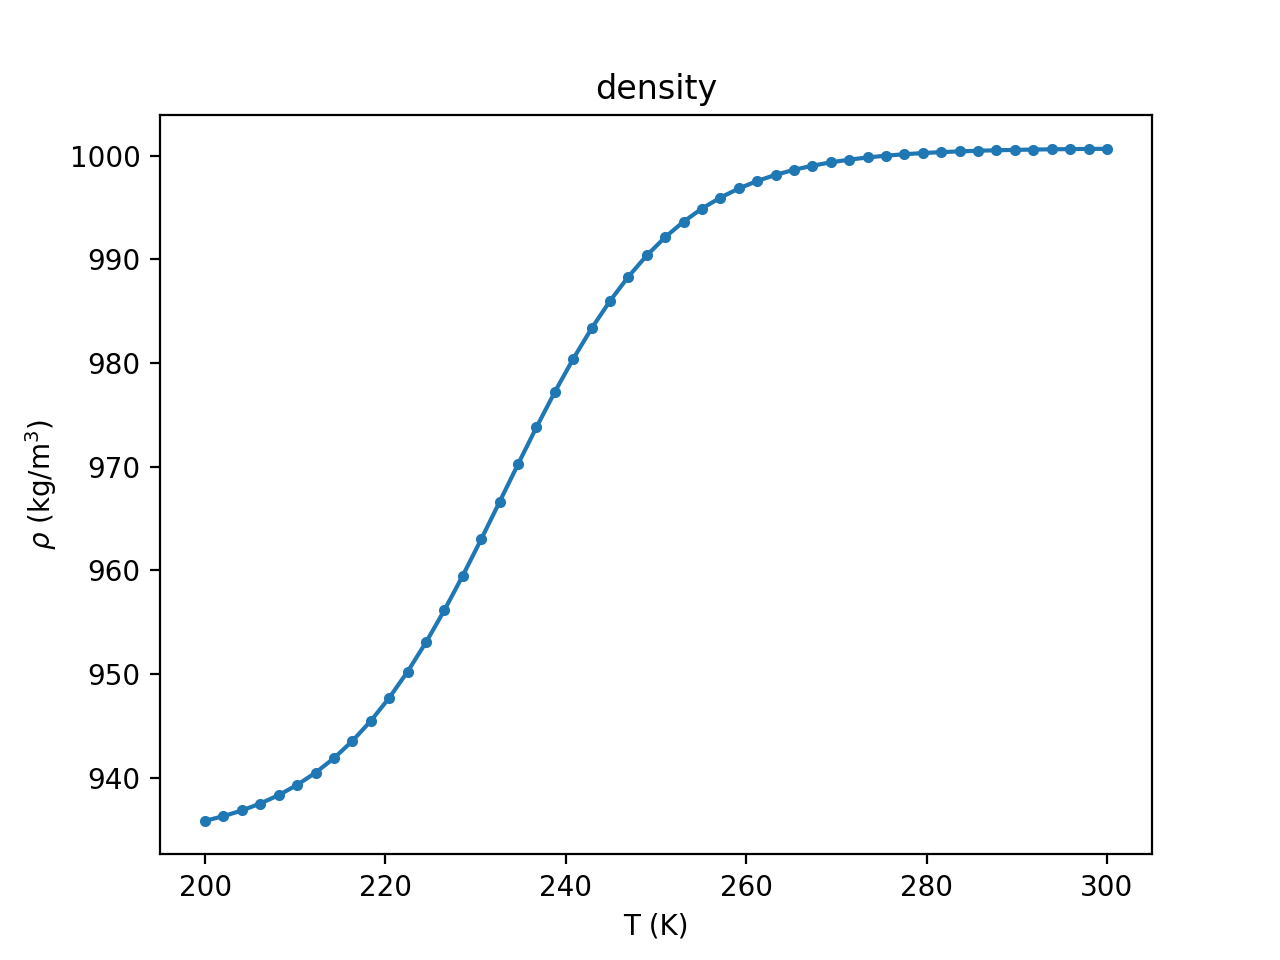

Text(0.5, 1.0, 'density')

In [12]:
rho_vals = density(temp,algorithm=1)

plt.figure()
plt.plot(temp,rho_vals,'.-')
plt.xlabel(r'T (K)')
plt.ylabel(r'$\rho$ (kg/m$^3$)')
plt.title('density')

<IPython.core.display.Javascript object>


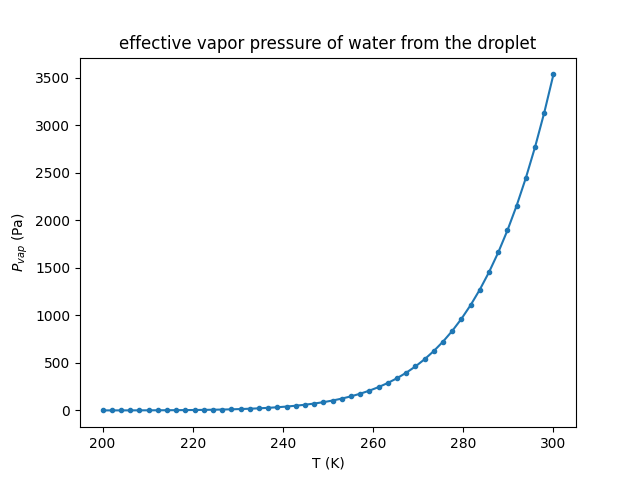

Text(0.5, 1.0, 'effective vapor pressure of water from the droplet')

In [474]:
Pv = Pvap(temp,P0=0,algorithm=1)

plt.figure()
plt.plot(temp,Pv,'.-')
plt.xlabel(r'T (K)')
plt.ylabel(r'$P_{vap}$ (Pa)')
plt.title('effective vapor pressure of water from the droplet')

<IPython.core.display.Javascript object>


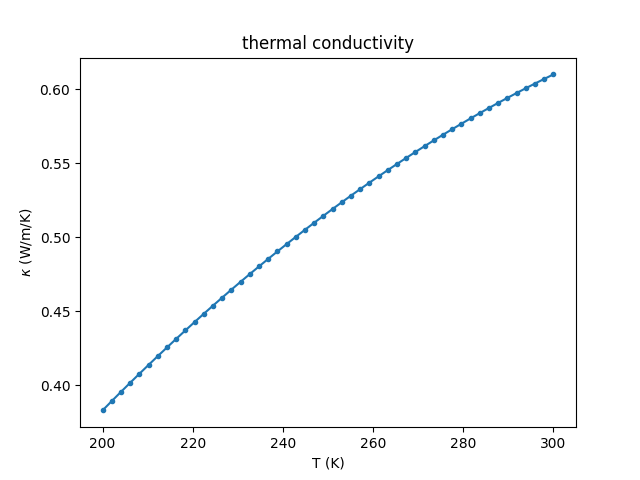

Text(0.5, 1.0, 'thermal conductivity')

In [475]:
kappa = thermal_cond(temp,algorithm=1)

plt.figure()
plt.plot(temp,kappa,'.-')
plt.xlabel(r'T (K)')
plt.ylabel(r'$\kappa$ (W/m/K)')
plt.title('thermal conductivity')

<IPython.core.display.Javascript object>


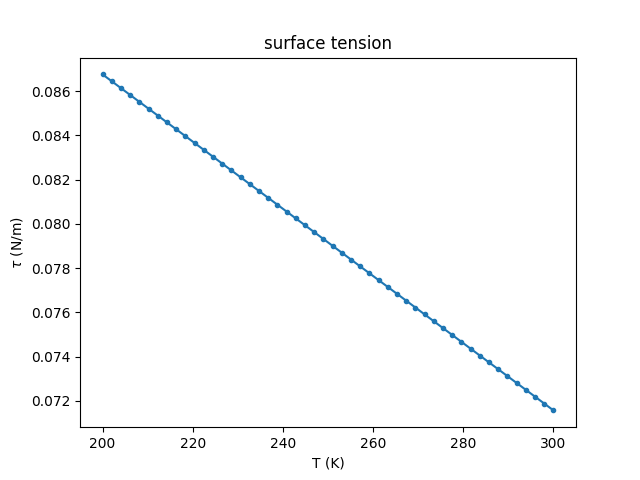

Text(0.5, 1.0, 'surface tension')

In [476]:
Gamma = surf_tension(temp,algorithm=1)

plt.figure()
plt.plot(temp,Gamma,'.-')
plt.xlabel(r'T (K)')
plt.ylabel(r'$\tau$ (N/m)')
plt.title('surface tension')

In [13]:
#from decimal import Decimal
#getcontext().prec = 10

In [20]:
#* Implementation notes: run
# * --------------------------------------------------------------
# * Calculates iteratively the Knudsen evaporation rate with
# * surface tension modification to the saturated vapor pressure
# * from the Kelvin equation, calculates the heat conduction
# * through the droplet via Fourier's law (given the input number
# * of shells), calculates the mass-loss due to evaporation.
# * Outputs the mass-averaged temperature of the droplet as a
# * function of travel time.

def EvapCool_run(save_dir):    
    
# ---------------- run parameters ------------------------
    
#  write out all relevant settings
   # print("#   Evaporative cooling of water droplets: %s initial settings" %configFile)
    print("#   --------------------------------------------------------------------")
    print("#   Droplet radius         r0 = %.3f um" %(r0*1e6))
    print("#   Initial temperature    T0 = %.3f K" %T0)
    print("#   Backpressure           P0 = %.3f Pa" %P0)
    print("#   Time step              dt = %.3f ns" %(dt*1e9))
    print("#   Number of shells   NShell = %d" %NShell)
    print("#   Number of steps    NSteps = %d" %NSteps)
    print("#   Evaporation coeff   gamma = %.1f" %g)
    print("#   Shell output        scale = %.1f" %scale)

    if (DHalgorithm == 1):
        print("#   Hvap  -- taken from Somayujulu, Int. J. Thermophysics 9, 567 (1988)")
    elif (DHalgorithm == 2):
        print("#   Hvap  -- taken from Murphy & Koop, Quarterly Journal of the Royal Meteorological Society 131, 1539 (2005)")
    elif (DHalgorithm == 3):
        print("#   Hvap  -- polynomial (T^5) fit to TIP4P/2005 simulation")
    elif (DHalgorithm == 4):
        print("#   Hvap  -- polynomial (T^5) fit to TIP4P/2005 simulation scaled by 0.9701 to fit experiment at r.t.")
    else:
        print("#   Hvap  -- taken from Somayujulu, Int. J. Thermophysics 9, 567 (1988)")
              
    if (Cpalgorithm == 1):
        print("#   Cp    -- taken from Angell, JPC 86, 998 (1982)")
    elif (Cpalgorithm == 2):
        print("#   Cp    -- taken from Huang & Bartell, JPC 99, 3924 (1995)")
    elif (Cpalgorithm == 3):
        print("#   Cp    -- taken from Oguni, JCP 73, 1948 (1980)")
    elif (Cpalgorithm == 4):
        print("#   Cp    -- constant (75.5 J/mol/K)")
    elif (Cpalgorithm == 5):
        print("#   Cp    -- polynomial (T^6) fit to experiment taken from Angell, JPC 86, 998 (1982)")
    elif (Cpalgorithm == 6):
        print("#   Cp    -- power law fit (Ts = 226 K) to experiment taken from Angell, JPC 86, 998 (1982)")
    elif (Cpalgorithm == 7):
        print("#   Cp    -- polynomial (T^8) fit to TIP4P/2005 simulation")
    elif (Cpalgorithm == 8):
        print("#   Cp    -- polynomial (T^8) fit to TIP4P/2005 simulation scaled by 0.8258 to fit experiment at r.t.")
    else:
        print("#   Cp    -- taken from Angell, JPC 86, 999 (1982)")

    if (rhoalgorithm == 1):
        print("#   rho   -- interpolation of experimental density data of ice (Ih = 0.934 g/cm^3) and water taken from Kell, Journal of Chemical Engineering Data 20, 97 (1975)")
    elif (rhoalgorithm == 2):
        print("#   rho   -- taken from Hare & Sorensen, JCP 87, 4840 (1987)")
    elif (rhoalgorithm == 3):
        print("#   rho   -- polynomial (T^6) fit to TIP4P/2005 simulation")
    elif (rhoalgorithm == 4):
        print("#   rho   -- polynomial (T^6) fit to TIP4P/2005 simulation scaled by 1.002 to reproduce experimental density maximum")
    else:
        print("#   rho   -- interpolation of experimental density data of ice (Ih = 0.934 g/cm^3) and water taken from Kell, Journal of Chemical Engineering Data 20, 97 (1975)")

    if (Pvapalgorithm == 1):
        print("#   Psat  -- taken from Murphy & Koop, Quarterly Journal of the Royal Meteorological Society 131, 1539 (2005)")
    elif (Pvapalgorithm == 2):
        print("#   Psat  -- taken from Hyland & Wexler, Special publication of the American Society of Heating, Project 216 (1982)")
    elif (Pvapalgorithm == 3):
        print("#   Psat  -- taken from Buck, Buck Research CR-1A User's Manual, Appendix 1 (1996)")
    elif (Pvapalgorithm == 4):
        print("#   Psat  -- recommended by WMO (2000), originally published by Goff, Transactions of the American Society of Heating and Ventilating Engineers, 347 (1957)")
    else:
        print("#   Psat  -- taken from from Murphy & Koop, Quarterly Journal of the Royal Meteorological Society 131, 1539 (2005)")

    if (kappaalgorithm == 1):
        print("#   kappa -- polynomial (T^4) fit to experiment taken from CRC Handbook of Chemistry and Physics, 2nd ed., E-10")
    elif (kappaalgorithm == 2):
        print("#   kappa -- taken from Ramires, NIST (1994)")
    else:
        print("#   kappa -- polynomial (T^4) fit to experiment taken from CRC Handbook of Chemistry and Physics, 2nd ed., E-10")

    if (taualgorithm == 1):
        print("#   tau   -- taken from Floriano & Angell, JCP 94, 10 (1990)")
    else:
        print("#   tau   -- taken from Floriano & Angell, JCP 94, 10 (1990)")

    print("#   --------------------------------------------------------------------")
    print("#   t [s]; T(t) [K]")

    # change precision of output
    # typedef numeric_limits<double> dbl;
    # cout.precision(dbl::digits10);
    
    
# ---------------- Physical constants --------------------

    # physical constants in SI units, NIST website
    NA      = 6.02214129e23                      # Avogadro's constant in 1/mol
    kB      = 1.3806488e-23                       # Boltzmann constant J/K
    Rgas    = 8.3144621                           # universal gas constant J/mol/K	
    molmass = 0.01801528                          # molecular mass of water in kg/mol
    mmolec  = molmass / NA                        # mass of one water molecule in kg
    fpi     = 4.0 * np.pi                         # frequently used constant (4*pi)
    RATE_CONST = 1 / np.sqrt(fpi * mmolec * kB / 2.0) # constant term in evaporation rate

    
# ---------------- Variable initialization ------------------

    outfreq  = int(np.round(NSteps/Nout)) # round up: (int) ceil(NSteps / (double) Nout)
    Tsurf    = T0
    dTsurf   = 0.0
    IntGamma = 0.0
    dr       = r0 / NShell
    Area     = np.pi * r0 * r0
    dVsurf   = fpi * (r0 * r0 * r0 - (r0 - dr) * (r0 - dr) * (r0 - dr)) / 3.0 
    
    # output arrays
    timearr = np.empty(NSteps // outfreq - 1)
    Tavearr = np.empty(NSteps // outfreq - 1)
    massarr = np.empty(NSteps // outfreq - 1)
    radarr = np.empty(NSteps // outfreq - 1)
    #Tgradarr = np.empty((NSteps // outfreq - 1)*NShell+1) # commented out by sharon
    # Tgradarr = np.empty[outfreq]
    
    # heat conduction variables	
    rad = np.empty(NShell+1) # outer shell radius
    for i in range(NShell+1):
        rad[i] = i*dr
    
    radm = np.empty(NShell+1) # inner shell radius
    for i in range(1, NShell+1):
        radm[i] = (i - 1) * dr
    radm[0] = 0.0
    
    rnew    = r0
    
    dV = np.empty(NShell+1) # shell volumina
    for i in range(NShell+1):
        dV[i] = fpi * (rad[i] * rad[i] * rad[i] - radm[i] * radm[i] * radm[i]) / 3.0 

    # array for the updated time step
    Tn = np.zeros(NShell+1)
    
    # initial condition: homogeneous temperature distribution
    Tm = np.ones(NShell+1)*T0

    # array for mass of individual shells for mass averaging of temperature
    mshell = np.zeros(NShell+1)

    # Calculations for evaporative cooling, including evaporation, 
    # heat conduction, mass loss, surface tension modification of vapor pressure

    for i in range(1,NSteps):

    # EVAPORATION ---------------------------------------------
        
        #calculate Knudsen evaporation rate [1/s]

        # without surface tension modification of Pvap
        #Gamma       =  Pvap(Tsurf, P0, Pvapalgorithm) * g * RATE_CONST * Area / sqrt(Tsurf) 

        # with surface tension modification of Pvap
        Gamma       =  Pvap(Tsurf, P0, Pvapalgorithm) * g * RATE_CONST * Area * np.exp(2.0 * surf_tension(Tsurf, taualgorithm) * molmass / (density(Tsurf, rhoalgorithm) * rnew * Rgas * Tsurf)) / np.sqrt(Tsurf)
        
        # temperature change of the evaporation shell [K]
        dTsurf      = - Gamma * (enthalpy_vap(Tsurf, DHalgorithm) / NA) * dt / ((heat_capacity(Tsurf, Cpalgorithm) / molmass) * dVsurf * density(Tsurf, rhoalgorithm))
        
        # integrate rate to obtain amount of particles lost [unitless]
        IntGamma   +=  Gamma * dt                                                      

        # update surface temperature after evaporation
        Tm[NShell]  = Tsurf + dTsurf

         #------------------------ heat conduction, loop over shells --------------------------------------

        for j in range(1, NShell):

            # calculate temperature gradients between shells
            dTl   = - Tm[j] + Tm[j - 1] # temp gradient, left shell boundary
            dTr   =   Tm[j] - Tm[j + 1] # temp gradient, right shell boundary

            # difference between heat gain and heat loss for each shell (Fourier's law)
            dQ    = fpi * dt * (thermal_cond(Tm[j], kappaalgorithm) * rad[j] * radm[j] * dTl - thermal_cond(Tm[j + 1], kappaalgorithm) * rad[j + 1] * radm[j + 1] * dTr) / dr

            # temperature change in each shell due to change of heat, array update
            dTemp = dQ / ((heat_capacity(Tm[j], Cpalgorithm) / molmass) * dV[j] * density(Tm[j], rhoalgorithm)) 
            Tn[j] = Tm[j] + dTemp


        # innermost shell: only heat loss, no gain 
        dTr        = Tm[0] - Tm[1]
        dQ         = - fpi * thermal_cond(Tm[0], kappaalgorithm) * rad[1] * rad[1] * dTr * dt / dr
        dTemp      = dQ / ((heat_capacity(Tm[0], Cpalgorithm) / molmass) * dV[1] * density(Tm[0], rhoalgorithm))
        Tn[0]      = Tm[0] + dTemp
        
        # outermost shell: only heat gain from conduction, no loss (only via evaporation)
        dTl        = - Tm[NShell] + Tm[NShell - 1]
        dQ         = fpi * thermal_cond(Tm[NShell], kappaalgorithm) * rad[NShell - 1] * radm[NShell - 1] * dTl * dt / dr
        dTemp      = dQ / ((heat_capacity(Tm[NShell], Cpalgorithm) / molmass) * dV[NShell] * density(Tm[NShell], rhoalgorithm))
        Tn[NShell] = Tm[NShell] + dTemp


        # temperature output for all shells individually before mass-weighted averaging
        #if (i % outfreq == 0): #{             # modulus division - commented our by sharon - not used
        
           # for (int l = 0; l < NShell; ++l) {
         #   for l in range(NShell): # commented out by sharon
                
               # Tgradarr[(i // outfreq - 1) * NShell + l] = Tn[l] # commented out by sharon
    
           # } # for l

        #} # if


        # mass-weighted averaging over the shells' temperatures
        Tave = 0.0
        mtot = 0.0
        
        for k in range(NShell):
            
            mshell[k] = dV[k] * density(Tn[k], rhoalgorithm)
            Tave     += Tn[k] * mshell[k]
            mtot     += mshell[k]
            

        Tave = Tave / mtot


        # output
        if (i % outfreq == 0):       # modulus division

            print(i * dt, "   ", Tave) # print temperature vs time

            timearr[i // outfreq - 1] = i * dt
            Tavearr[i // outfreq - 1] = Tave
            radarr[i // outfreq - 1]  = rnew
            massarr[i // outfreq - 1] = currelnum

        
# ---------------------------- Mass loss due to evaporation ----------------------------------------- 
        

        # update geometrical properties due to massloss

        # current relative number of molecules in the droplet and initial number
        currelnum = 1.0 - 3.0 * mmolec * IntGamma / (fpi * r0 * r0 * r0 * density(Tave, rhoalgorithm))
        
        # rnew = r0 # test without massloss
        rnew = (r0 * r0 * r0 * currelnum)**(1.0 / 3.0)
        # rnew   = (r0 * r0 * r0 - 3.0 * mmolec * IntGamma / (fpi * density(Tave, rhoalgorithm)))**(1.0 / 3.0)
        dr     = rnew / NShell

        for i in range(NShell+1):
            rad[i] = i * dr

        for i in range(NShell+1):
            radm[i] = (i - 1) * dr

        radm[0] = 0.0
        Area    = fpi * rnew * rnew

        for i in range(NShell+1):
            dV[i] = fpi * (rad[i] * rad[i] * rad[i] - radm[i] * radm[i] * radm[i]) / 3.0
        
        dVsurf = fpi * (rnew * rnew * rnew - (rnew - dr) * (rnew - dr) * (rnew - dr)) / 3.0

        # update surface and shell temperatures 
        Tsurf = Tn[NShell]
        # Tsurf = Tm[NShell]  # test for evaporation ALONE!

        for j in range(NShell+1):
            Tm[j] = Tn[j]

    
    print("#   --------------------------------------------------------------------")
    
    # added by sharon:
    # save data:
    np.save(save_dir+'/time', timearr)
    np.save(save_dir+'/Tave', Tavearr)
    np.save(save_dir+'/rad', radarr)
    np.save(save_dir+'/mass', massarr)

    #return 0
    return timearr, Tavearr

In [21]:
!pwd

/Users/sharonberkowicz/Nextcloud/Research/SACLA_Oct2022/evaporative_cooling


In [29]:
# input parameters:

test = False
date = '20221021'

r0 = 100e-6/2 # initial droplet radius m
NShell=100 # no shells
dt=1.0e-8   # time step length s
NSteps=100000 # no of time steps
print('total time', NSteps*dt*1e3, 'ms')
scale=10
Nout=10              # no of time steps to save data (save every outfreq = NSteps/Nout)
g=1.0
T0=295.0             # initial temperature of the sample K
P0=0.1*1e-3*1e5      # chamber pressure Pa
#output=evapcool-largerdrop_sharon_test.h5
save_dir = f'/Users/sharonberkowicz/Nextcloud/Research/SACLA_Oct2022/evaporative_cooling/results/%s_%.d_%.d_%.d' %(date,2*r0*1e9,P0,T0)

if not os.path.exists(save_dir) and not test:
        os.mkdir(save_dir)

# choose experimental parameter algorithms:
DHalgorithm=1
Cpalgorithm=1
rhoalgorithm=1
Pvapalgorithm=1
kappaalgorithm=1
taualgorithm=1

total time 1.0 ms


In [30]:
t, T = EvapCool_run(save_dir)

#   --------------------------------------------------------------------
#   Droplet radius         r0 = 50.000 um
#   Initial temperature    T0 = 295.000 K
#   Backpressure           P0 = 10.000 Pa
#   Time step              dt = 10.000 ns
#   Number of shells   NShell = 100
#   Number of steps    NSteps = 100000
#   Evaporation coeff   gamma = 1.0
#   Shell output        scale = 10.0
#   Hvap  -- taken from Somayujulu, Int. J. Thermophysics 9, 567 (1988)
#   Cp    -- taken from Angell, JPC 86, 998 (1982)
#   rho   -- interpolation of experimental density data of ice (Ih = 0.934 g/cm^3) and water taken from Kell, Journal of Chemical Engineering Data 20, 97 (1975)
#   Psat  -- taken from Murphy & Koop, Quarterly Journal of the Royal Meteorological Society 131, 1539 (2005)
#   kappa -- polynomial (T^4) fit to experiment taken from CRC Handbook of Chemistry and Physics, 2nd ed., E-10
#   tau   -- taken from Floriano & Angell, JCP 94, 10 (1990)
#   ----------------------------------------

<IPython.core.display.Javascript object>


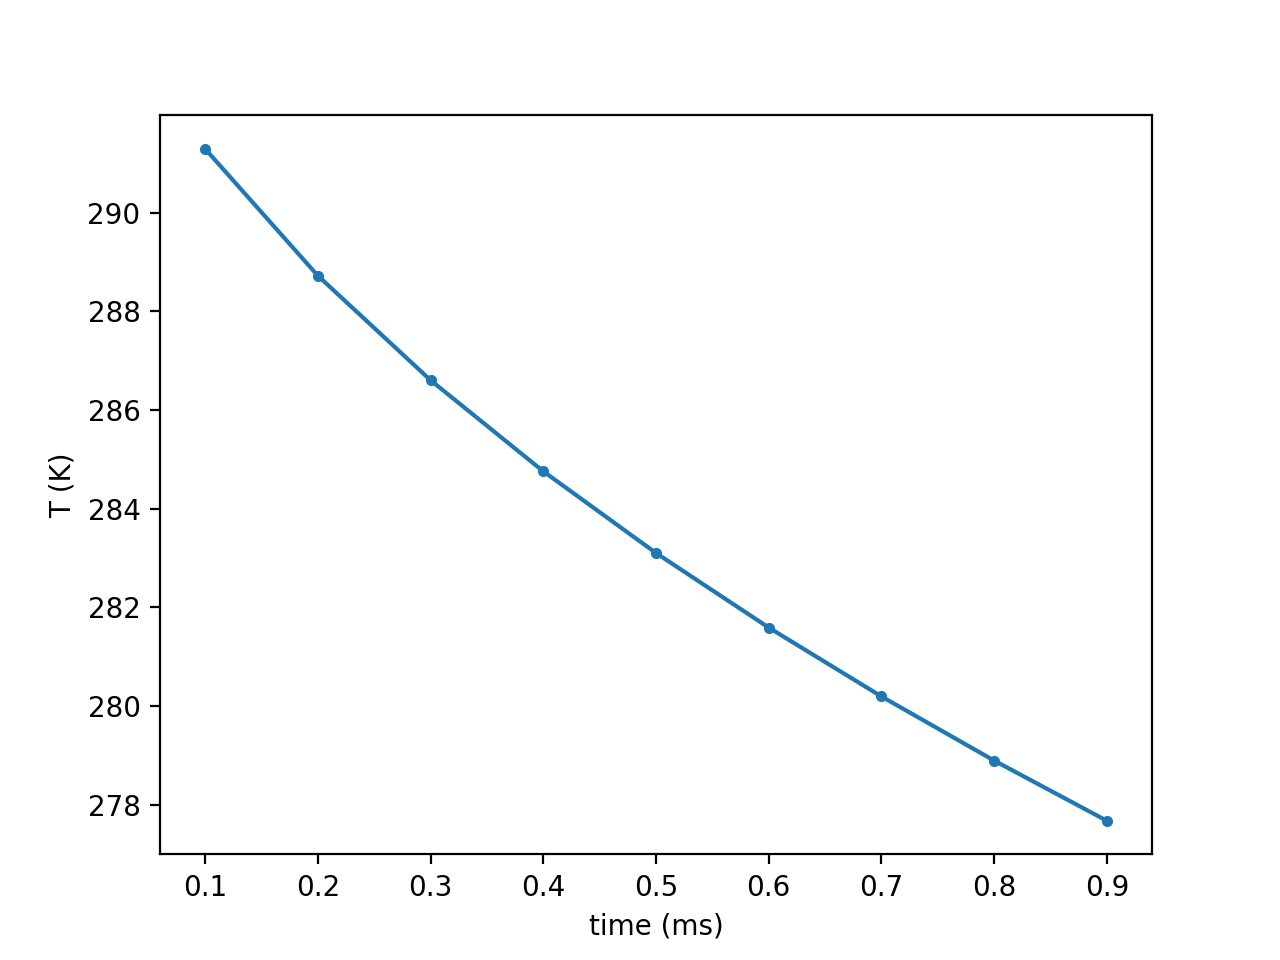

<IPython.core.display.Javascript object>


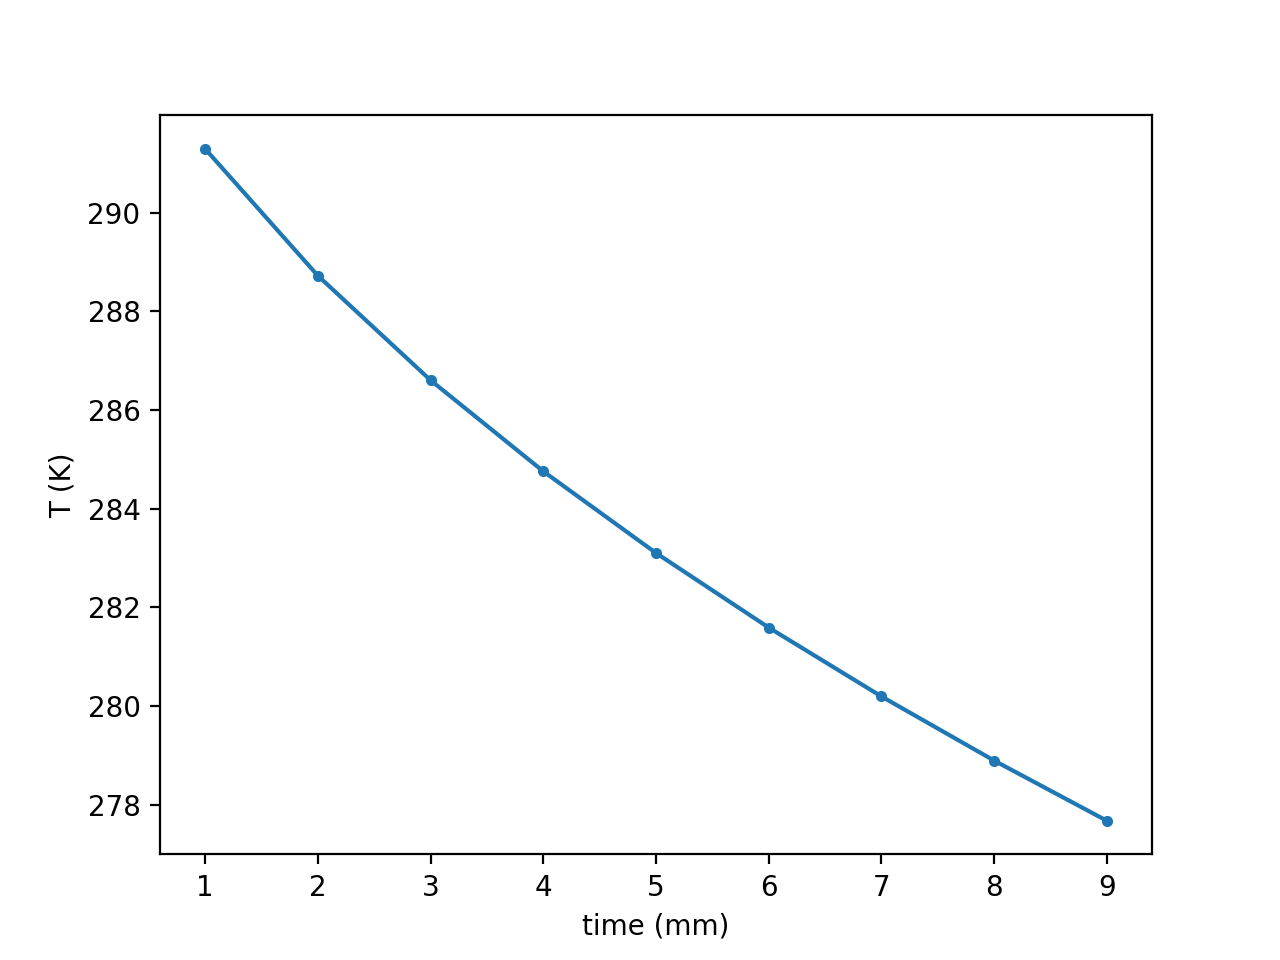

Text(0, 0.5, 'T (K)')

In [33]:
velocity = 10 # droplet velocity m/s

plt.figure()
plt.plot(t*1e3,T, '.-')
plt.xlabel('time (ms)')
plt.ylabel('T (K)')


plt.figure()
plt.plot(velocity*t*1e3,T, '.-')
plt.xlabel('time (mm)')
plt.ylabel('T (K)')

# My tests

### input parameters

In [264]:
gamma = 1    # evaporation coefficient (gamma=1 used for pure water) 
# is the ratio between the experimental rate of evaporation and the theoretical maximum value

kB = 1.38064852e-23 # boltzmann constant J/K
R = 8.3145          # ideal gas constant J/K mol
NA = 6.023e23       # avogadro constant molecules/mol

Pv=1  # partial vapor pressure

Ps0=1 # saturation vapor pressure for flat surface
Gamma=72e-3 # surface tension at 25 degC, N/m
Vm = 20.6 # molar volume

#Hvap # enthalpy of vaporization
#rho  # density
#Cp   # specific heat capacity at constant pressure

#kappa # thermal conductivity

### Functions

In [332]:
# r: droplet radius
# T: temperature
# Pv: vapor partial pressure
# Ps0: saturation vapor pressure for flat surface
# Gamma: surface tension
# Vm: molar volume
# rho: liquid density
# Hvap: enthalpy of vaporization
# Cp: specific heat capacity at constant pressure
# kappa: thermal conductivity
# Ms: mass of spherical shell of thickness dr
# dr: spherical shell thickness
# nmax: no of shells

def evap_cool_rate(r, T, Ms):
    " Evaporative cooling rate, dTs/dt at droplet surface i.e. the outermost shell "
    
    rho = density(T, rhoalgorithm)             # density
    Cp = heat_capacity(T, Cpalgorithm)         # specific heat capacity at constant pressure (J/mol/K)
    Hvap = enthalpy_vap(T, DHalgorithm)        # enthalpy of vaporization (J/mol)
    Gamma = surf_tension(T, taualgorithm)      # surface tension
    Pv = Pvap(T, P0, Pvapalgorithm)            # vapor partial pressure in the chamber
    Vm = Mw/rho                                # molar volume = molar mass[kg/mol]/density[kg/m^3]
   # m_loss = # mass of the evaporating molecules
    
    Ps = Ps0*np.exp(2*Gamma*Vm/(r*R*T))        # Ps(T) is the (corrected) saturation vapour pressure
    Jmax = (Ps-Pv)/np.sqrt(2*np.pi*Mw*kB*T)    # rate of evaporation
    As = 4*np.pi*r**2                          # droplet surface area
    Vs = Ms/rho                                # interfacial evaporation volume
    
    dTs_dt = -gamma*Jmax * As*Hvap/(Cp*rho*Vs) # evaporative cooling rate
    return dTs_dt

def delta_Tn(rn, dr, Ms, Tn, Tn1, dt):
    " Temperature change in a spherical shell "
    
    kappa = thermal_cond(Tn, kappaalgorithm)
    Cp = heat_capacity(Tn, Cpalgorithm)
    
    # radius at the center of the shell: rn+dr/2
    dQ_dt = -4*np.pi*(rn+dr/2)**2 * kappa * (Tn1-Tn) / dr  # heat flow through nth shell
    delta_Qn = dQ_dt*dt
    
    delta_Tn = delta_Qn/(Cp*Ms) # temperature change ∆Tn of a unit step in time for the nth shell 
    return delta_Tn

def droplet_temp(r, nmax, dt, T0):
    " Mass-averaged droplet temperature after time step dt for initial temperature T0 " 
    
    dr = r/nmax                     # shell thickness
    T = np.ones(nmax+1)*T0            # T0: initial droplet temperature
    Ms = np.empty(nmax+1)                                    
    
    for n in range(nmax+1):
        rn = r-n*dr                                # radius of shell n, starting from outer shell
        
        if n==0: # outermost shell - heat gain + heat loss by evaporation
            rho = density(T[0], rhoalgorithm) 
            Ms[0] =  rho*4*np.pi*(rn**3-(rn-dr)**3)            # mass of shell n
            Tsurf = T[0] - evap_cool_rate(rn, T[0], Ms[0])*dt  # evaporative cooling at surface 
            delta_T = delta_Tn(rn, dr, Ms[n], T[0], Tsurf, dt) # heat loss between inner shells
            
        elif n==nmax: # innermost shell - only heat loss 
            rho = density(T[n], rhoalgorithm)                  # density of shell n
            Ms[n] =  rho*4*np.pi*(rn**3-(rn-dr)**3)            # mass of shell n
            delta_T = delta_Tn(rn, dr, Ms[n], T[n], T[n-1], dt) # heat loss between inner shells
            
        else:
            rho = density(T[n], rhoalgorithm)                  # density of shell n
            Ms[n] =  rho*4*np.pi*(rn**3-(rn-dr)**3)            # mass of shell n
            delta_T1 = delta_Tn(rn, dr, Ms[n], T[n], T[n+1], dt)   # heat transfer between inner shells
            delta_T2 = delta_Tn(rn, dr, Ms[n], T[n], T[n+1], dt)   # heat transfer between inner shells
            
        T[n] = T0-delta_T                           # nth shell temperature
        Tn1 = T[n+1]                                  # temperature in n+1 shell

    print(delta_T)    
    average_temp = np.sum(T*Ms)/np.sum(Ms)          # mass-averaged droplet temperature
    return average_temp


In [333]:
r = 13e-6/2  # droplet radius
T00 = 293.15 # initial droplet temperature K
P0 = 0.1     # chamber pressure
v = 15       # droplet velocity m/s 

nmax = 100   # number of shells
Nsteps = 1   # no of time steps
dt = 1e-7    # time step s

x = 0.0            # molar fraction glycerol
Mw_wat = 18.01528e-3  # molar mass water kg/mol
Mw_gly = 92.09382e-3
Mw = x*Mw_gly+(1-x)*Mw_wat  # mass of evaporating molecules
print(Mw*1e3)

DHalgorithm=1
Cpalgorithm=1
rhoalgorithm=1
Pvapalgorithm=1
kappaalgorithm=1
taualgorithm=1

times = np.linspace(0,dt*Nsteps,Nsteps)
times

18.01528


array([0.])

In [334]:
for t in times:
   
    if t==0:
        T0=T00
    else:
        T0= dropT
    
    dropT = droplet_temp(r,nmax,dt,T0)
                            
    print(t*1e3, dropT)

-33149010381558.203


IndexError: index 101 is out of bounds for axis 0 with size 101

In [221]:
# rayleigh liquid jet breakup

r = 5e-6 # jet radius m
print('jet diameter', 2*r*1e6, 'um')
rho = 997 # density kg/m^3 at 25C
Gamma = 72e-3 # surface tension N/m at 25C
eta = 0.8891e-3 # viscosity at 25C Pa*s
u = 15 # jet velocity m/s

T = 298 # K
R = 8.3145 # J/Kmol
P = 1.013e5 # air pressure Pa
Mg = (28*0.79+32*0.21)*1e-3 # air molar mass kg/mol
rho_g = P/(R*T)*Mg # n/V*M = P/RT*M [kg/m^3]
print('rho/rho_g', rho/rho_g) 
#The upper bound separating the Rayleigh regime from the first wind-induced regime We<0.4*rho/rho_g

# stable laminar liquid flow occurs for low Reynolds’ numbers, Re = vρd/σ < 2000
Re = (u*rho*2*r)/Gamma
print('Re', Re)

Oh = eta/np.sqrt(Gamma*rho*r)
print('Oh',Oh)

We = r*rho*u**2/Gamma # jet regime if We>4. 
print('We>4 for jetting?', We)
print('We*rho/rho_g<0.2 for jetting?', We*rho_g/rho) 

t_R = np.sqrt(rho * r**3 / Gamma)
l_R = u * t_R 
print(t_R*1e3, 'ms')
print(l_R*1e3, 'mm')

jet diameter 10.0 um
rho/rho_g 845.5569404263301
Re 2.077083333333334
Oh 0.04693013253547415
We>4 for jetting? 15.578125000000002
We*rho/rho_g<0.2 for jetting? 0.01842350793329838
0.0013156377836539123 ms
0.019734566754808683 mm


In [223]:
L = 2*r*19.5*(np.sqrt(We)*(1 + 3*Oh))**0.85 # ?
print(L*1e3)

L = r*np.sqrt(We) # same as above
print(L*1e3)

L = r*np.sqrt(rho/rho_g)
print(L*1e3)

L = r/(1/np.sqrt(We)+1/np.sqrt(rho_g/rho))
print(L*1e3)

L = 2*r*8.51*(We/2)**0.32 
print(L*1e3)

0.7006135672460005
0.019734566754808683
0.14539230898042116
0.00017046331460171288
0.1641363684937656
